In [1]:
import os
import numpy as np
from sklearn.decomposition import NMF
from sonnmf.main import sonnmf
import matplotlib.pyplot as plt

In [2]:
def sample_dirichlet(alpha, N):
    k = len(alpha)
    theta = np.zeros((N, k))
    scale = 1
    for i in range(k):
        theta[:, i] = np.random.gamma(alpha[i], scale, N)
    S = np.sum(theta, axis=1)
    theta = theta / np.tile(S.reshape(-1, 1), (1, k))
    return theta


def create_synthetic_data():
    Wt = np.array([[1, 0, 0, 1], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1]])
    r = 4

    n = 500
    purity = 0.8
    alpha = 0.05 * np.ones((r, 1))
    Ht = sample_dirichlet(alpha, n).T
    for j in range(n):
        while np.max(Ht[:, j]) > purity:
            Ht[:, j: j+1] = sample_dirichlet(alpha, 1).T
    epsilon = 0.01
    Xt = np.dot(Wt, Ht)
    X = np.maximum(0, Xt + epsilon * np.random.randn(*Xt.shape))
    return X, Wt, Ht


def plot_3d(X, Wt, W, filepath):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='red', marker='o', s=144)
    ax.scatter(W[0, :], W[1, :], W[2, :], c='black', marker='x', s=144)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath)
    else:
        plt.show()

def save_results(filepath, W, H, fscores, gscores, hscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

In [3]:
data_filepath = '../datasets/synthetic_data.npz'
ini_filepath = '../saved_models/synthetic/r{}_ini.npz'

In [4]:
if os.path.exists(data_filepath):
    data = np.load(data_filepath)
    M = data['M']
    W_true = data['W_true']
    H_true = data['H_true']
else:
    M, W_true, H_true = create_synthetic_data()
    with open(data_filepath, 'wb') as fout:
        np.savez_compressed(fout, M=M, W_true=W_true, H_true=H_true)

In [5]:
m, n = M.shape
max_iters = 10000
r = 8

if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [6]:
# W, _, _, _, _, _ = load_results('../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'.format(4, 0.001, 0.1, 10000))
# plot_3d(M, W_true, W, '../images/synthetic/r{}_l{}_g{}_it{}.png'.format(4, 0.001, 0.1, 10000))

In [ ]:
save_filepath = f'../saved_models/synthetic/vanilla_r{r}_it{max_iters}.npz'

model = NMF(n_components=r, init='custom', random_state=42, max_iter=max_iters)
W = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
H = model.components_
with open(save_filepath, 'wb') as fout:
    np.savez_compressed(fout, W=W, H=H)

In [ ]:
row_labels = ['Rank 4', 'Rank 8']
col_labels = ['Vanilla NMF', 'Vanilla NMF \n (L2 norm adjusted)', 'SONNMF']

fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, len(col_labels) + 1, width_ratios=[0.1] + len(col_labels) * [1])

for i, rlabel in enumerate(row_labels):
    txt_ax = fig.add_subplot(gs[i, 0])
    txt_ax.text(0.5, 0.5, rlabel, ha='center', va='center', fontsize=18)
    txt_ax.axis('off')

r = 4
vW1 = np.load('../saved_models/synthetic/vanilla_r{}_it{}.npz'.format(r, max_iters))['W']
col_norm_vW1 = np.linalg.norm(vW1, axis=0, ord=2, keepdims=True)
vW1_re = vW1 / col_norm_vW1
# vH1_re = vH1 * col_norm_vW1.T
cW1, _, _, _, _, _ = load_results('../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'.format(r, 0.001, 0.1, 10000))

for i, curr_W in enumerate([vW1, vW1_re, cW1]):
    curr_subplot = fig.add_subplot(gs[0, i+1], projection='3d')
    plot_3d(curr_subplot, M, W_true, curr_W)
    curr_subplot.set_title(col_labels[i], fontsize=18)


r = 8
vW2 = np.load('../saved_models/synthetic/vanilla_r{}_it{}.npz'.format(r, max_iters))['W']
col_norm_vW2 = np.linalg.norm(vW2, axis=0, ord=2, keepdims=True)
vW2_re = vW2 / col_norm_vW2
# vH2_re = vH2 * col_norm_vW2.T
cW2, _, _, _, _, _ = load_results('../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'.format(r, 0.01, 0.5, 10000))

for i, curr_W in enumerate([vW2, vW2_re, cW2]):
    plot_3d(fig.add_subplot(gs[1, i+1], projection='3d'), M, W_true, curr_W)

# adjust spacing between subplots
fig.tight_layout(pad=1.0)
plt.savefig('../images/synthetic/vanilla_vs_sonnmf.png')

In [ ]:
iters = [1, 10, 100]
save_filepath = '../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'

for it in iters:
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=0.01, gamma=0.5, itermax=it, W_update_iters=10, early_stop=True, verbose=False)
    save_results(save_filepath.format(r, 0.01, 0.5, it), W, H, fscores, gscores, hscores, total_scores)

TypeError: 'Axes3DSubplot' object is not subscriptable

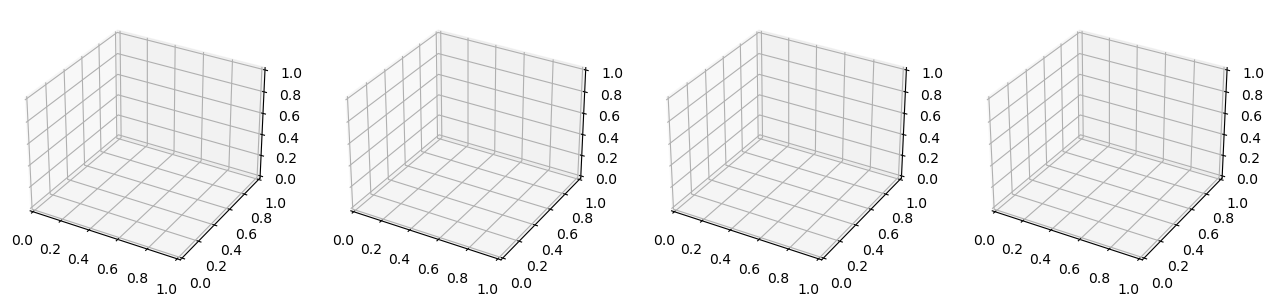

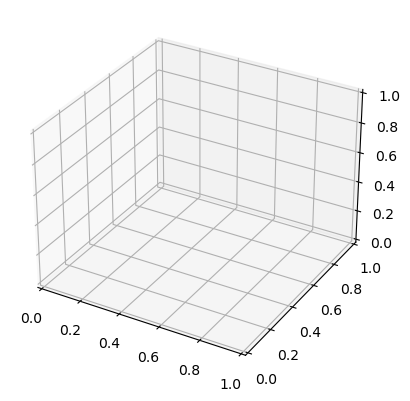

In [8]:
fig = plt.figure(figsize=(20, 5))
axs = [fig.add_subplot(1, 5, i+1, projection='3d') for i in range(4)]
#
# plot_3d(axs[0], M, W_true, ini_W)
# axs[0].set_title('Initial')


# Loop over iterations and plot W using plot_3d function
for i, it in enumerate([1, 10, 100, 1000]):
    W, _, _, _, _, _ = load_results('../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'.format(r, 0.01, 0.5, it))
    plot_3d(axs[i], M, W_true, W)
    axs[i+1].set_title('{} iterations'.format(it))
fig.legend(['Data points', 'True W', 'Estimated W'],
                 bbox_to_anchor=(0.85, 0.85, 0, 0))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2)
plt.savefig('../images/synthetic/iterations2.png')